# Sonification Seizures with Ising Trotter Frequency Modulation

In [3]:
import numpy as np
from scipy.io.wavfile import read, write
from scipy.io import wavfile
from scipy.signal import butter, lfilter, medfilt
import matplotlib.pyplot as plt
import re

In [4]:
from pathlib import Path

def list_filenames(folder_path):
    """
    Returns a list of file names (not directories) in the given folder.
    """
    folder = Path(folder_path)
    return [folder_path + p.name for p in folder.iterdir() if p.is_file()]

def list_modulation_matrices(folder_path):
    folder = Path(folder_path)
    pid = f"patient{patientID}"

    return [str(p) for p in folder.iterdir() if p.is_file() and pid in p.name and "obs" in p.name]


def get_latest_fm_data(candidates):
    fname = max(candidates, key=lambda f: int(re.search(r"simulator_(\d+)", f).group(1)))
    print(fname)
    return np.loadtxt(fname, delimiter=',')


In [5]:
import numpy as np
from scipy.io.wavfile import write
SAMPLE_RATE   = 44_100
NOTE_DURATION = 0.10          
FM_RATIO      = 2.0           

def generate_wave(pitches, note_duration=0.33, sample_rate=44100):
    """Generate a waveform based on a list of pitches (frequencies)."""
    waveform = np.array([], dtype=np.float32)

    for freq in pitches:
        t = np.linspace(0, note_duration, int(sample_rate * note_duration), endpoint=False)
        wave = 0.5 * np.sin(2 * np.pi * freq * t)  # sine wave generation
        waveform = np.concatenate((waveform, wave))
    
    return waveform

def load_time_series(filename, step = 500): # N = 1000
    """Load every `step`-th line from a time series file."""
    times = []
    values = []
    
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i % step == 0:  # Keep only every 50th line
                try:
                    time, value = map(float, line.strip().split())
                    times.append(time)
                    values.append(value)
                except ValueError:
                    continue  # Skip malformed lines
    
    return np.array(times), np.array(values)

def fm_note(f_c, I, duration, sample_rate, fm_ratio):
    """Return one FM note of length `duration`."""
    t   = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
    f_m = f_c * fm_ratio
    return np.sin(2*np.pi*f_c*t + I*np.sin(2*np.pi*f_m*t))

def generate_wave_fm_segmented(pitches, segment_indices,
                               note_duration=NOTE_DURATION,
                               sample_rate=SAMPLE_RATE,
                               fm_ratio=FM_RATIO):
    """
    FM-synth an entire channel where the *first N/9 notes* use segment_indices[0],
    the next N/9 use segment_indices[1], and so on.
    """
    n_notes   = len(pitches)
    n_segments = len(segment_indices)
    seg_size  = max(1, n_notes // n_segments)
    waveform  = []

    for n, f_c in enumerate(pitches):
        seg_id = min(n_segments-1, n // seg_size)
        I      = segment_indices[seg_id]
        waveform.append(0.5 * fm_note(f_c, I, note_duration,
                                      sample_rate, fm_ratio))

    return np.concatenate(waveform, dtype=np.float32)



def sonify_files(paths, mod_T):
    if len(paths) != mod_T.shape[0]:
        raise ValueError(f"Mismatch: {len(paths)} files but {mod_T.shape[0]} channels in modulation matrix.")

    waves = []
    for i, path in enumerate(paths):
        _, values = load_time_series(path)

        # map to C4–B5
        vals_norm = (values - np.min(values)) / (np.ptp(values) + 1e-12)
        freqs     = 261.63 + vals_norm * (1244.51 - 261.63)

        waves.append(generate_wave_fm_segmented(freqs, mod_T[i]))

    L     = max(len(w) for w in waves)
    mix   = np.sum([np.pad(w, (0, L-len(w))) for w in waves], axis=0)
    mix  /= np.max(np.abs(mix)) + 1e-12
    return mix


In [17]:
patientID = 2

datapath = f'channels_for_sonification/patient{patientID}/'
fm_datapath = f'computed_sonification_data/'
file_paths = list_filenames(datapath)
fm_file_paths = list_modulation_matrices(fm_datapath)
print(file_paths)
print(fm_file_paths)
modulation_matrix = get_latest_fm_data(fm_file_paths)
print(modulation_matrix*10)



['channels_for_sonification/patient2/LALT4_no_first.txt', 'channels_for_sonification/patient2/LAST3_no_first.txt', 'channels_for_sonification/patient2/LALT5_no_first.txt', 'channels_for_sonification/patient2/LALT3_no_first.txt', 'channels_for_sonification/patient2/LAST2_no_first.txt']
['computed_sonification_data/patient2_data_seizure_aer_simulator_2_obs.txt', 'computed_sonification_data/patient2_data_seizure_aer_simulator_3_obs.txt', 'computed_sonification_data/patient2_data_seizure_aer_simulator_1_obs.txt']
computed_sonification_data/patient2_data_seizure_aer_simulator_3_obs.txt
[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00

In [71]:
# # Generate and combine waveforms from the files
combined_waveform = sonify_files(file_paths, modulation_matrix.T)

# # Output file path for the saved .wav file
output_file = f"output/patient{patientID}_combined_sonification_FM.wav"

# # Save the combined waveform as a 16-bit WAV file
write(output_file, 44100, (combined_waveform * 32767).astype(np.int16))  # Scale to 16-bit PCM format

print(f"Saved combined melody as a wav file to {output_file}")

Saved combined melody as a wav file to output/patient1_combined_sonification_FM.wav


In [72]:
# low-pass filter

In [73]:
from scipy.signal import butter, lfilter

In [74]:
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import butter, lfilter, medfilt
import matplotlib.pyplot as plt

def lowpass_filter(data, cutoff=2000, sample_rate=44100, order=5):
    """Apply a low-pass Butterworth filter."""
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

def remove_clicks(audio_data, kernel_size=7):
    """Apply a median filter to remove sharp transient clicks."""
    return medfilt(audio_data, kernel_size=kernel_size)

def process_audio(input_path, output_path, cutoff = 2000, kernel_size = 10):
    # Load the WAV file
    sample_rate, data = read(input_file)

    # If stereo, take only one channel
    if data.ndim > 1:
        data = data[:, 0]

    # Normalize if in int16 format
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32767.0

    # Step 1: Low-pass filter
    filtered = lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate)

    # Step 2: Click removal via median filtering
    cleaned = remove_clicks(filtered, kernel_size=kernel_size)

    # Normalize output to avoid clipping
    cleaned = cleaned / np.max(np.abs(cleaned))

    # Save the result
    write(output_file, sample_rate, (cleaned * 32767).astype(np.int16))
    
    

In [18]:
input_file = f"output/patient{patientID}_combined_sonification_FM.wav"
output_file = f"output/patient{patientID}_combined_filtered_and_declicked_FM.wav"



# process_audio(input_file, output_file, cutoff = 5000, kernel_size=7)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


def plot_spectrogram(
    title,
    wav_path,
    savefig=None,
    nfft=2048,
    noverlap=1536,
    cmap="cividis",
    db_floor=-90
):
    """
    Paper-style spectrogram plot with viridis colormap.
    Uses log-scaled power in dB with a clean dynamic range.
    """

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 22,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.linewidth": 1.2
    })

    sample_rate, data = wavfile.read(wav_path)

    # convert stereo -> mono
    if data.ndim > 1:
        data = data[:, 0]

    # normalize if integer wav
    if np.issubdtype(data.dtype, np.integer):
        data = data.astype(np.float32) / np.iinfo(data.dtype).max
    else:
        data = data.astype(np.float32)

    fig, ax = plt.subplots(figsize=(12, 5.5))

    # spectrogram returns:
    # Pxx: power spectral density
    # freqs: frequency bins
    # bins: time bins
    # im: AxesImage
    Pxx, freqs, bins, im = ax.specgram(
        data,
        Fs=sample_rate,
        NFFT=nfft,
        noverlap=noverlap,
        cmap=cmap,
        scale="dB",
        mode="psd"
    )

    # Set dynamic range (avoid washed-out plot)
    vmax = np.max(10 * np.log10(Pxx + 1e-12))
    vmin = vmax + db_floor
    im.set_clim(vmin, vmax)

    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")

    # cleaner grid (very subtle)
    ax.grid(False)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Power (dB)", rotation=270, labelpad=18)

    plt.tight_layout()

    if savefig is not None:
        plt.savefig(savefig, format="pdf", bbox_inches="tight")

    plt.show()


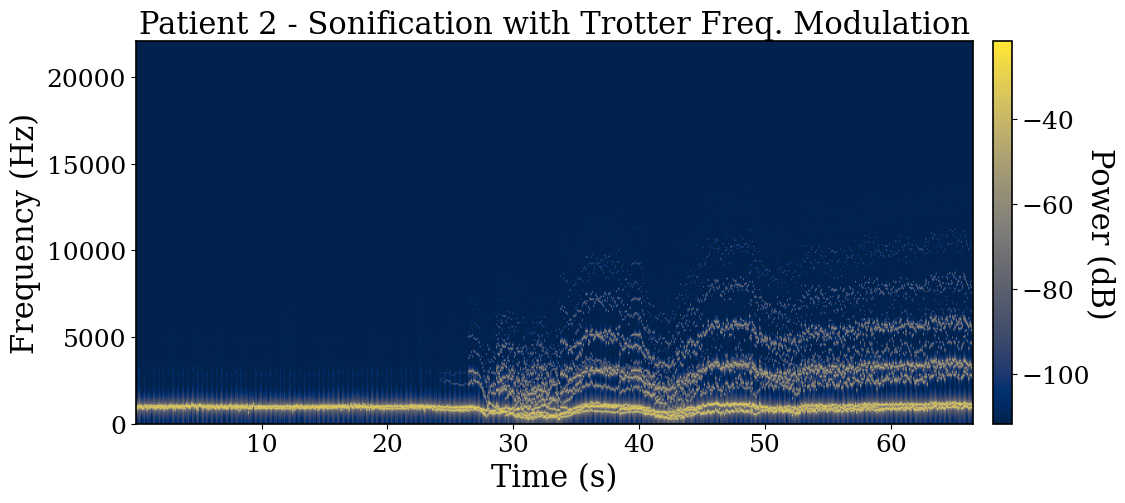

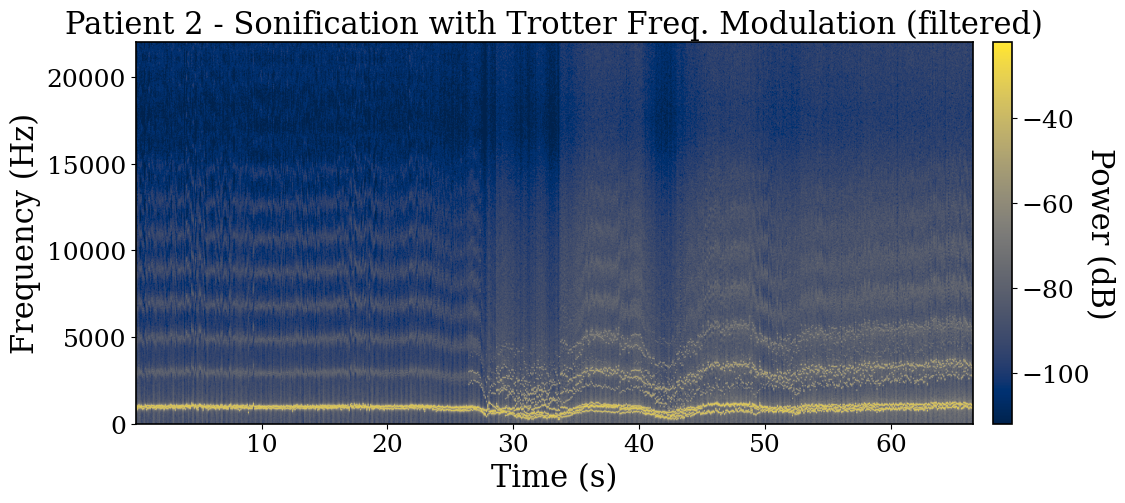

In [20]:
plot_spectrogram(f"Patient {patientID} - Sonification with Trotter Freq. Modulation", input_file, savefig=f"spectrogram_of_sonified_time_series_epilepsy_patient{patientID}_plus_Trotter_FM_cividis.pdf")
plot_spectrogram(f"Patient {patientID} - Sonification with Trotter Freq. Modulation (filtered)", output_file, savefig=f"spectrogram_of_sonified_and_filtered_time_series_epilepsy_patient{patientID}_plus_Trotter_FM_cividis.pdf")
